<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sobel
1. 3*3 以某像素為中心, 擷取特徵
2. 為何是3*3 : GPU 優化處理過
3. 為何不用5*5 ... : 利用深度替代
4. 如何擷取特徵 : 透過9個數值差, 來強調`邊緣`

In [1]:
from urllib.request import urlretrieve

url = "https://github.com/Elwing-Chou/tibaml0315/raw/main/bg%20morning.png"
urlretrieve(url, "test.png")

('test.png', <http.client.HTTPMessage at 0x7f02f8392110>)

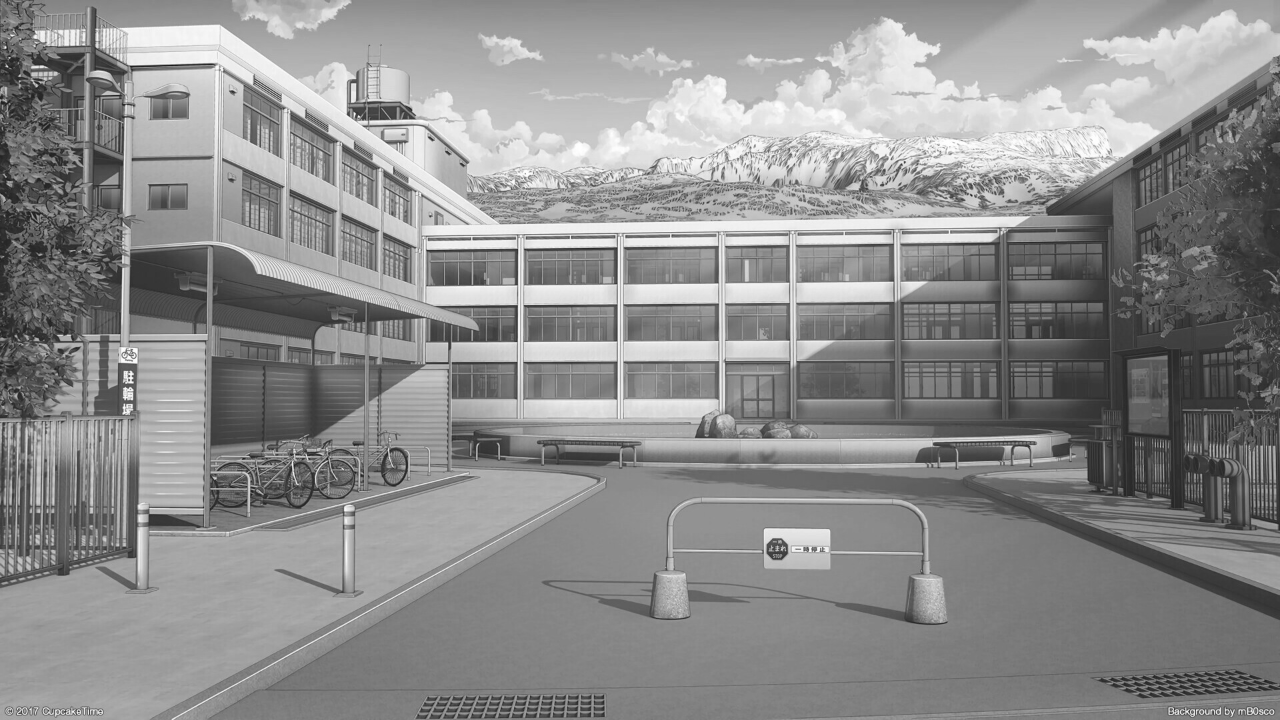

In [2]:
import numpy as np
from PIL import Image

img = Image.open("test.png").convert("L")
img_np = np.array(img)
img

In [3]:
img_np.shape

(720, 1280)

In [4]:
# Gx  (直線)

Gx = [
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]

def combine(img, ci, cj, g):
    # ci, cj: center -1: top left
    si, sj = ci-1, cj-1
    total = 0.0
    for i in range(3):
        for j in range(3):
            total = total + img[si+i][sj+j] * g[i][j]
    return abs(total)

img_gx = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gx[i][j] = combine(img_np, i, j, Gx)

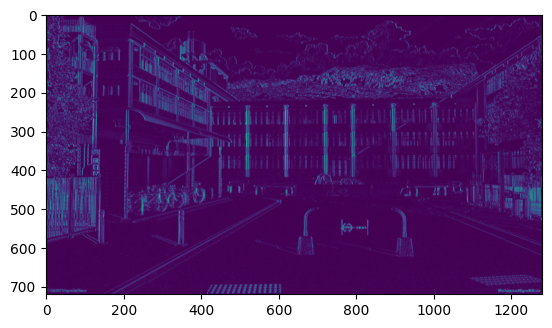

In [5]:
import matplotlib.pyplot as plt

# 0~255(ok) 0.0~1.0(ok)
# 0~1: (pi - min) / (max - min)
ma = img_gx.max()
mi = img_gx.min()
img_norm = (img_gx - mi) / (ma - mi)
plt.imshow(img_norm)

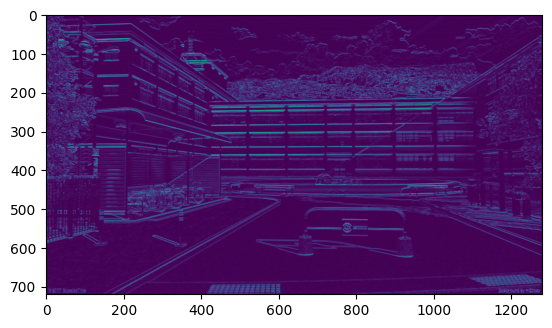

In [6]:
# Gy  (橫線)

Gy = [
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]

img_gy = np.zeros(img_np.shape)
h, w = img_np.shape
for i in range(1, h-1):
    for j in range(1, w-1):
        img_gy[i][j] = combine(img_np, i, j, Gy)

ma = img_gy.max()
mi = img_gy.min()
img_norm = (img_gy - mi) / (ma - mi)
plt.imshow(img_norm)

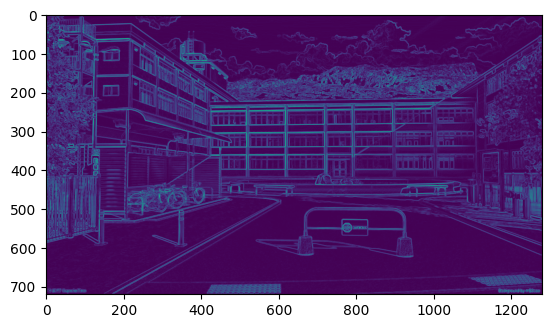

In [7]:
#　Gx + Gy

img_g = (img_gx ** 2 + img_gy ** 2) ** 0.5
ma = img_g.max()
mi = img_g.min()
img_norm = (img_g - mi) / (ma - mi)
plt.imshow(img_norm)

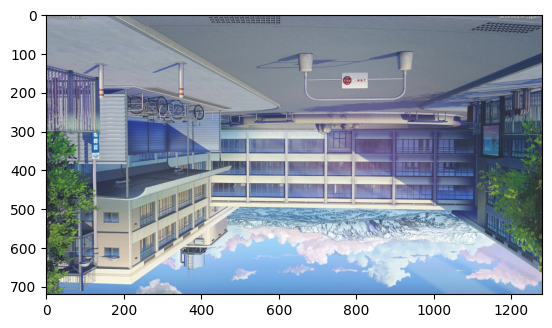

In [8]:
# 圖像操作  (np.array操作 -> 對某一個軸, 都進行一個list操作)

img = Image.open("test.png").convert("RGB")
img_np = np.array(img)

# 左右相反
plt.imshow(img_np[:, ::-1, :])

# 上下相反
plt.imshow(img_np[::-1, :, :])

# CIFAR 10


In [9]:
# import datasets

from tensorflow.keras.datasets import cifar10
( (x_train, y_train), (x_test, y_test) ) = cifar10.load_data()

170498071/170498071 [==============================] - 7s 0us/step


In [10]:
# check shape

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [11]:
# (50000, 1) 原資料型態是為了未來擴充達案的可能性, 這邊不需要, 所以reshape

y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

In [12]:
# 轉換答案的list
trans = [ 
    "airplane",										
    "automobile",										
    "bird",										
    "cat",										
    "deer",										
    "dog",										
    "frog",										
    "horse",										
    "ship",										
    "truck"
]

dog


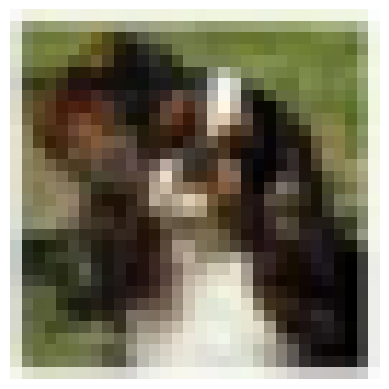

In [13]:
# check image

from PIL import Image
index = 500
plt.imshow(x_train[index])
plt.axis("off")

print(trans[y_train[index]])

In [14]:
# build model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

layers = [
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")
]

model = Sequential(layers)
model.summary()

# summary 解析
# filter 3 * 3   RGB 3
# conv 64
# 27 * 64 + 64 = 1792 

# filter 3 * 3   64
# conv 128
# 576 * 128 + 128 = 73856

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [15]:
# 資料預處理
# x : 0 ~ 1
# y : one-hot encoding (轉為10個機率)
# CIFAR10 僅有10種分類, 為了避免日後大量分類的任務 -> 稀疏矩陣 Sparse
# y : 配合loss 使用 SparseCategoricalCrossentropy -> 第0類, Spare 自動轉為index0 = 1

x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

In [16]:
# compile (確定損失函式)
# 避免分類太多而消耗過多的RAM
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# optimizer
# 局部最佳 vs 全局最佳
# 使用 optimizer 是為了避免分析結果停在 "鞍點" (局部最佳, 全局最佳, 通常差異不會太大)
# 速度, 時間&步長 優化 -> adam 一次全部解決

model.compile(loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
        optimizer="adam")

In [17]:
# fit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback_list = [
    ModelCheckpoint("cifar10.h5", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True)
]
model.fit(x_train_norm,
     y_train,
     batch_size=100,
     epochs=40,
     validation_split=0.1,
     callbacks=callback_list)

Epoch 1/40
450/450 [==============================] - 14s 10ms/step - loss: 1.7365 - accuracy: 0.3628 - val_loss: 1.4617 - val_accuracy: 0.4698
Epoch 2/40
450/450 [==============================] - 4s 8ms/step - loss: 1.3978 - accuracy: 0.4987 - val_loss: 1.3182 - val_accuracy: 0.5264
Epoch 3/40
450/450 [==============================] - 4s 8ms/step - loss: 1.2531 - accuracy: 0.5512 - val_loss: 1.1527 - val_accuracy: 0.5828
Epoch 4/40
450/450 [==============================] - 4s 9ms/step - loss: 1.1389 - accuracy: 0.5937 - val_loss: 1.1380 - val_accuracy: 0.5944
Epoch 5/40
450/450 [==============================] - 4s 8ms/step - loss: 1.0541 - accuracy: 0.6262 - val_loss: 1.0505 - val_accuracy: 0.6262
Epoch 6/40
450/450 [==============================] - 4s 8ms/step - loss: 0.9749 - accuracy: 0.6560 - val_loss: 1.0312 - val_accuracy: 0.6438
Epoch 7/40
450/450 [==============================] - 4s 8ms/step - loss: 0.9168 - accuracy: 0.6782 - val_loss: 0.9234 - val_accuracy: 0.6782
Epoc

In [18]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7097 - accuracy: 0.7618


[0.7096844911575317, 0.7617999911308289]

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pre = model.predict(x_test_norm).argmax(axis=1)
mat = confusion_matrix(y_test, pre)
pd.DataFrame(mat,
       index=["{}(true)".format(trans[i]) for i in range(10)],
       columns=["{}(pred)".format(trans[i]) for i in range(10)])

313/313 [==============================] - 2s 4ms/step


,airplane(pred),automobile(pred),bird(pred),cat(pred),deer(pred),dog(pred),frog(pred),horse(pred),ship(pred),truck(pred)
airplane(true),736,18,75,18,38,7,17,9,64,18
automobile(true),11,904,7,7,4,2,9,3,16,37
bird(true),38,2,673,55,91,40,79,18,4,0
cat(true),10,5,66,589,54,152,87,18,12,7
deer(true),7,3,53,51,759,40,47,35,5,0
dog(true),8,4,26,175,38,682,25,35,4,3
frog(true),2,1,30,40,33,24,861,2,5,2
horse(true),10,3,38,33,78,48,8,777,0,5
ship(true),30,29,17,12,15,6,14,0,869,8
truck(true),30,99,9,16,8,9,14,19,28,768


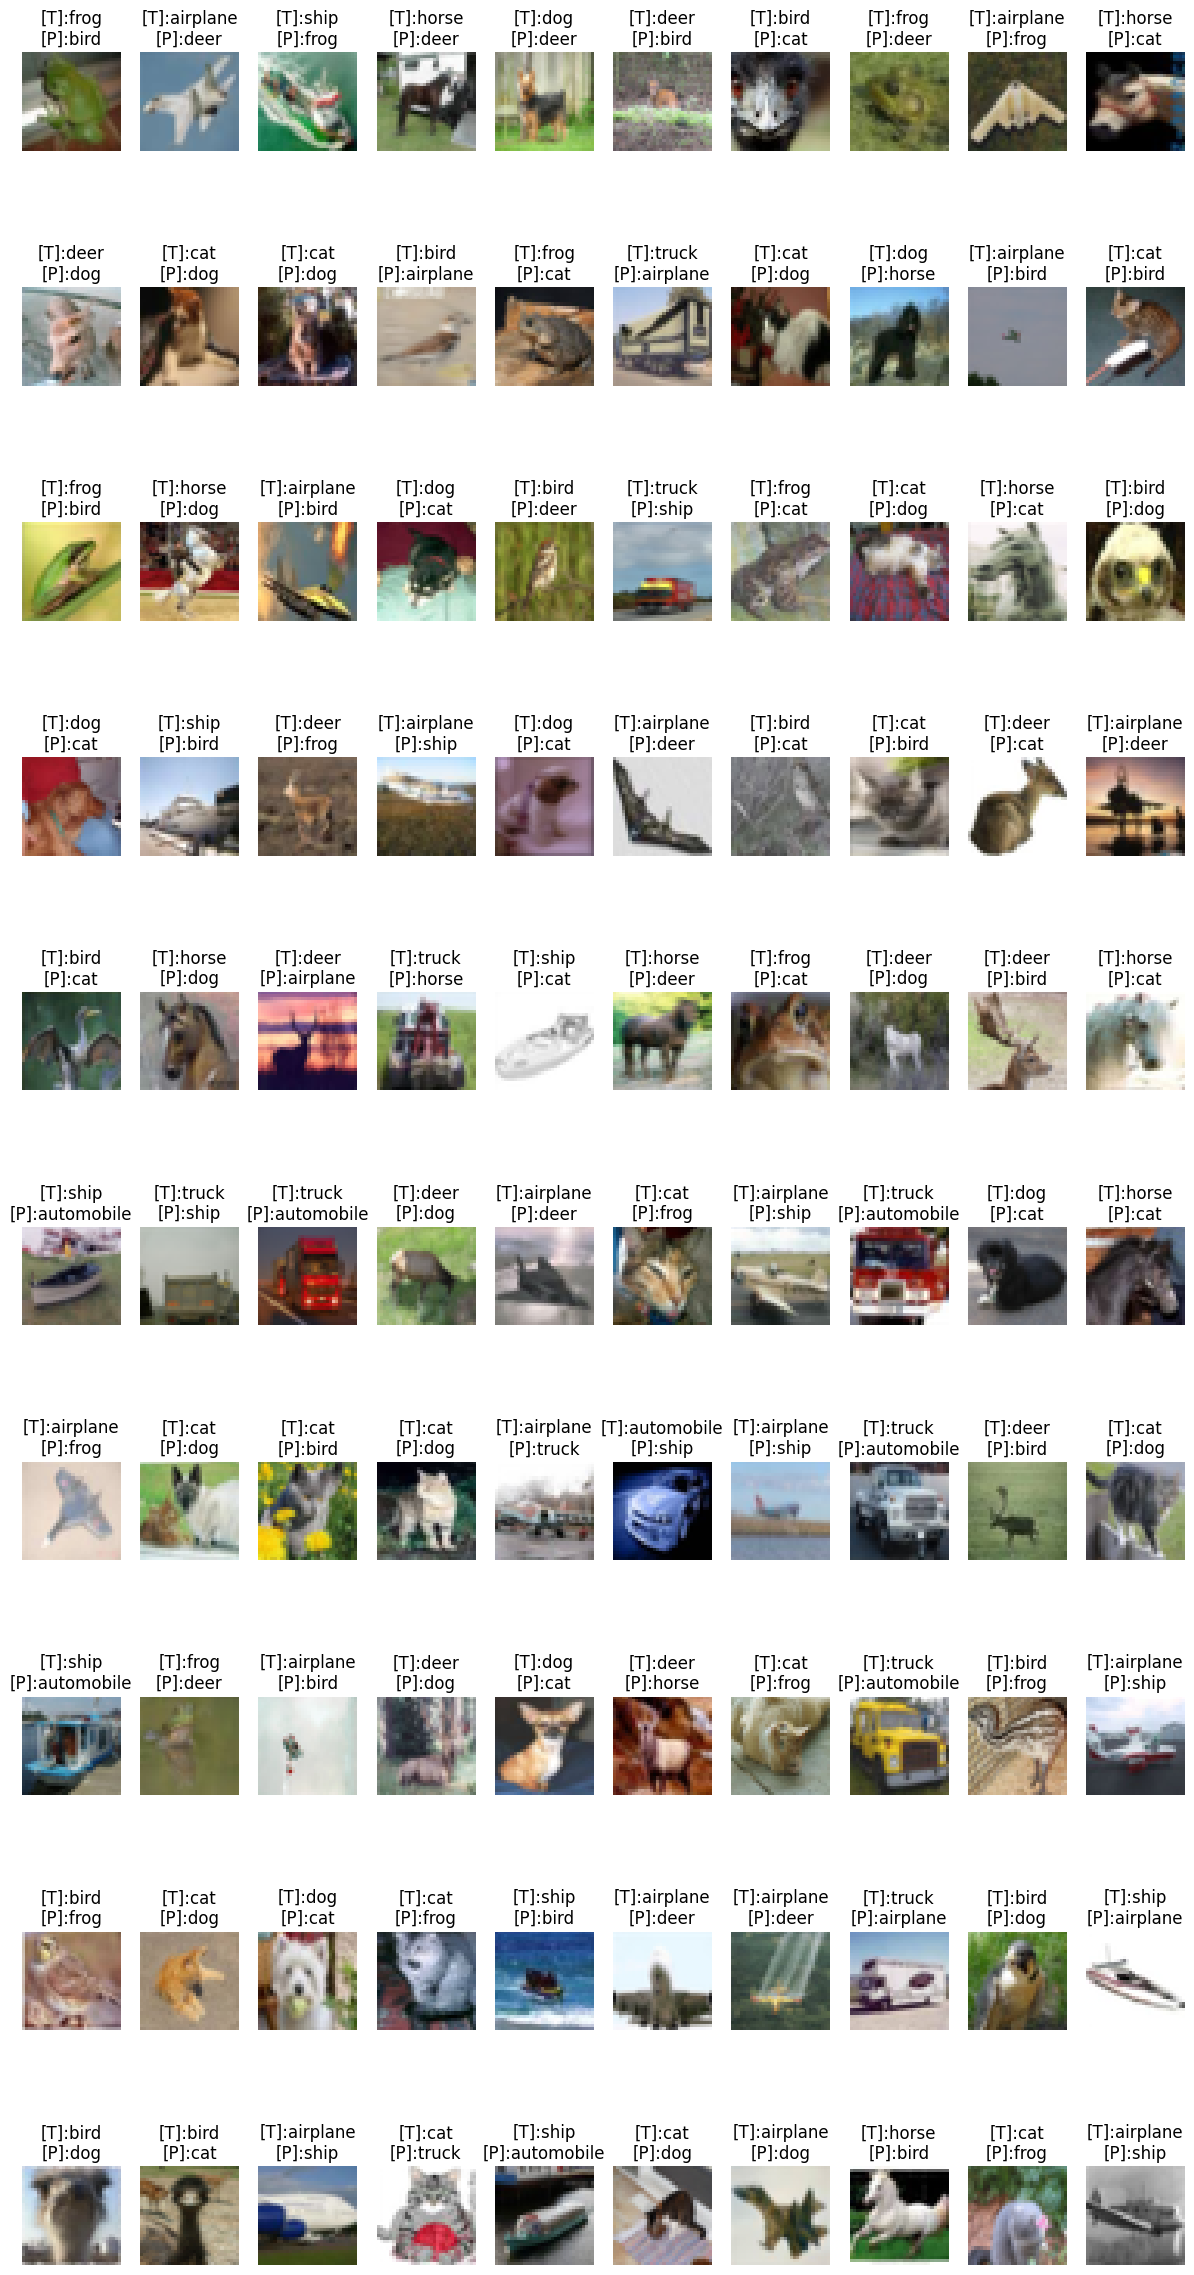

In [20]:
import numpy as np
idx = np.nonzero(y_test != pre)[0]
idx = idx[:100]
plt.figure(figsize=(15, 30))
# 預測錯誤的預測值
fp_pred = pre[idx]
# 預測錯誤的真實值
fp_true = y_test[idx]
# 預測錯誤的圖片
fp_img = x_test[idx]
for i in range(len(idx)):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    t = "[T]:{}\n[P]:{}".format(trans[fp_true[i]], trans[fp_pred[i]])
    plt.title(t)
    plt.imshow(fp_img[i])